<a href="https://colab.research.google.com/github/20hnu/time_series/blob/main/Time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import sklearn

In [89]:
series = pd.read_csv("/content/drive/MyDrive/EDA/monthly-robberies.csv",header=0,index_col=0)
split_point = len(series) -12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)


Dataset 106, Validation 12


In [63]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106 entries, 1966-01 to 1974-10
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Robberies  106 non-null    int64
dtypes: int64(1)
memory usage: 1.7+ KB


In [64]:
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [65]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [66]:
history = [ x for x in train]
predictions = list()
for i in range(len(test)):
  yhat = history[-1]
  predictions.append(yhat)
  history.append(test[i])
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, test[i]))

mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=174.000, Expected=178.000
>Predicted=178.000, Expected=136.000
>Predicted=136.000, Expected=161.000
>Predicted=161.000, Expected=171.000
>Predicted=171.000, Expected=149.000
>Predicted=149.000, Expected=184.000
>Predicted=184.000, Expected=155.000
>Predicted=155.000, Expected=276.000
>Predicted=276.000, Expected=224.000
>Predicted=224.000, Expected=213.000
>Predicted=213.000, Expected=279.000
>Predicted=279.000, Expected=268.000
>Predicted=268.000, Expected=287.000
>Predicted=287.000, Expected=238.000
>Predicted=238.000, Expected=213.000
>Predicted=213.000, Expected=257.000
>Predicted=257.000, Expected=293.000
>Predicted=293.000, Expected=212.000
>Predicted=212.000, Expected=246.000
>Predicted=246.000, Expected=353.000
>Predicted=353.000, Expected=339.000
>Predicted=339.000, Expected=308.000
>Predicted=308.000, Expected=247.000
>Predicted=247.000, Expected=257.000
>Predicted=257.000, Expected=322.000
>Predicted=322.000, Expected=298.000
>Predicted=298.000, Expected=273.000
>

#Data Analysis

In [67]:
dataset.describe()

,Robberies
count,106.000000
mean,173.103774
std,112.231133
min,29.000000
25%,74.750000
50%,144.500000
75%,271.750000
max,487.000000


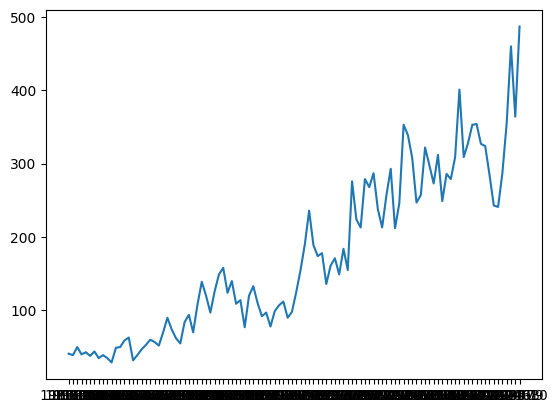

In [68]:
plt.plot(dataset)
plt.show()

Some observations from the plot include:

* There is an increasing trend of robberies over time.
* There do not appear to be any obvious outliers.
* There are relatively large fluctuations from year to year, up and down.
* The fluctuations at later years appear larger than fluctuations at earlier years.
* The trend means the dataset is almost certainly non-stationary and the apparent change in fluctuation may also contribute.

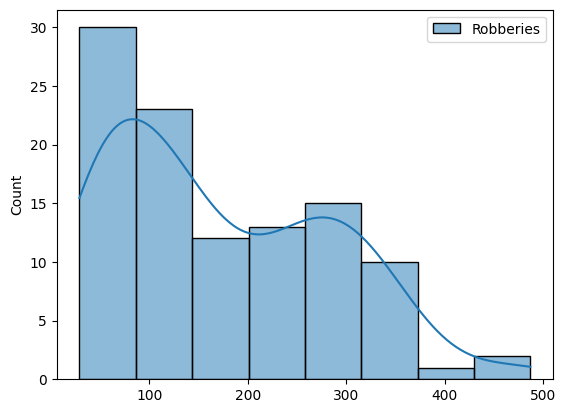

In [69]:
import seaborn as sns
sns.histplot(dataset, kde =True)
plt.show()

Some observations from the plots include:

* The distribution is not Gaussian.
* The distribution is left shifted and may be exponential or a double Gaussian.

In [70]:
dataset.index = pd.to_datetime(dataset.index)

In [71]:
groups = dataset['1966':'1973'].groupby(pd.Grouper(freq='A'))
groups

In [72]:
annual_sums = groups.sum()
annual_sums

,Robberies
Month,
1966-12-31,482
1967-12-31,672
1968-12-31,1178
1969-12-31,1352
1970-12-31,1753
1971-12-31,2503
1972-12-31,3285
1973-12-31,3751


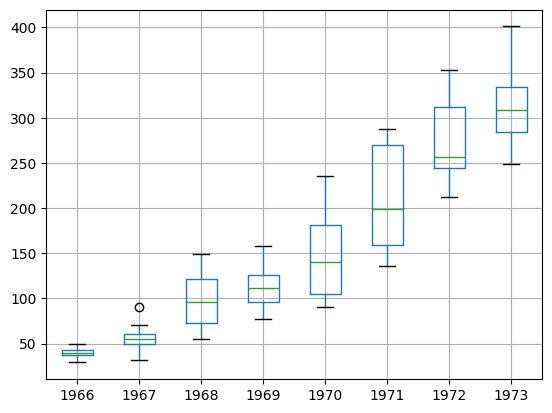

In [73]:
groups = dataset['1966':'1973'].groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
  years[name.year] = group["Robberies"].values
years.boxplot()
plt.show()


In [74]:
dataset.index

DatetimeIndex(['1966-01-01', '1966-02-01', '1966-03-01', '1966-04-01',
               '1966-05-01', '1966-06-01', '1966-07-01', '1966-08-01',
               '1966-09-01', '1966-10-01',
               ...
               '1974-01-01', '1974-02-01', '1974-03-01', '1974-04-01',
               '1974-05-01', '1974-06-01', '1974-07-01', '1974-08-01',
               '1974-09-01', '1974-10-01'],
              dtype='datetime64[ns]', name='Month', length=106, freq=None)

##ARIMA MODELS

In [75]:
from statsmodels.tsa.stattools import adfuller

#create a differe
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return pd.Series(diff)

X = dataset.values
# difference data
stationary = difference(X)
stationary.index = dataset.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))


ADF Statistic: -3.980946
p-value: 0.001514
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


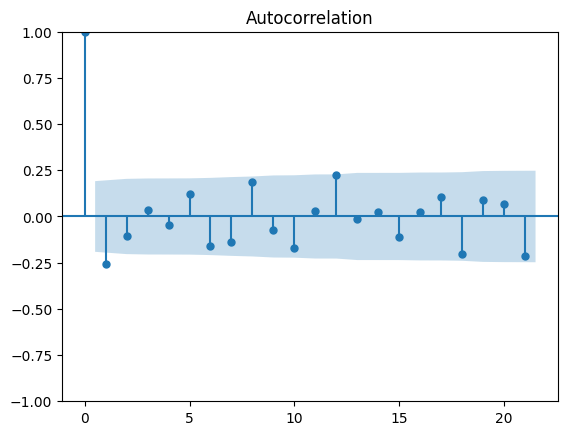

In [76]:
# pacf ans ACF plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(stationary)
plt.show()

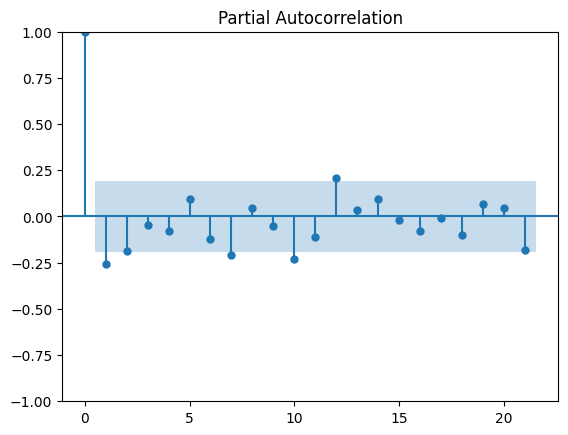

In [77]:
plot_pacf(stationary)
plt.show()

Below are some observations from the plots.

* The ACF shows a significant lag for 1 month.
* The PACF shows a significant lag for perhaps 2 months, with significant lags spotty out to perhaps 12 months.
* Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA.
* A good starting point for the p and q values is 1 or 2.

In [78]:
from statsmodels.tsa.arima.model import ARIMA

history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(0,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=180.705, Expected=178.000
>Predicted=179.873, Expected=136.000
>Predicted=141.098, Expected=161.000
>Predicted=166.173, Expected=171.000
>Predicted=167.005, Expected=149.000
>Predicted=150.656, Expected=184.000
>Predicted=182.314, Expected=155.000
>Predicted=154.213, Expected=276.000
>Predicted=245.214, Expected=224.000
>Predicted=225.902, Expected=213.000
>Predicted=216.867, Expected=279.000
>Predicted=258.698, Expected=268.000
>Predicted=263.377, Expected=287.000
>Predicted=279.945, Expected=238.000
>Predicted=251.485, Expected=213.000
>Predicted=226.574, Expected=257.000
>Predicted=249.690, Expected=293.000
>Predicted=277.211, Expected=212.000
>Predicted=230.020, Expected=246.000
>Predicted=245.786, Expected=353.000
>Predicted=317.992, Expected=339.000
>Predicted=313.734, Expected=308.000
>Predicted=305.556, Expected=247.000
>Predicted=263.416, Expected=257.000
>Predicted=272.428, Expected=322.000
>Predicted=310.225, Expected=298.000
>Predicted=288.644, Expected=273.000
>

##Grid Search:
* p: 0 to 12.
* d: 0 to 3.
* q: 0 to 12.

In [79]:
def evaluate_model(x, arima_order):
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
      # predict
      model = ARIMA(history, order=arima_order)
      model_fit = model.fit()
      yhat = model_fit.forecast()[0]
      predictions.append(yhat)
      # observation
      obs = test[i]
      history.append(obs)
      print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    # report performance
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [80]:
def evaluate_model_parameters(dataset, p_values, q_values, d_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          rmse = evaluate_model(dataset, order)
          if rmse < best_score:
            best_score, best_cfg = rmse, order
          print('ARIMA%s RMSE=%.3f' % (order,rmse))
        except:
          continue
  print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [81]:
import warnings
p_values = range(0, 12)
d_values = range(0, 3)
q_values = range(0, 12)
warnings.filterwarnings("ignore")
#evaluate_model_parameters(train,p_values,d_values,q_values)

In [82]:
%%capture
!pip install pmdarima

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=519.904, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=521.682, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=521.501, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=518.614, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.605 seconds
Best ARIMA order: (0, 1, 0)


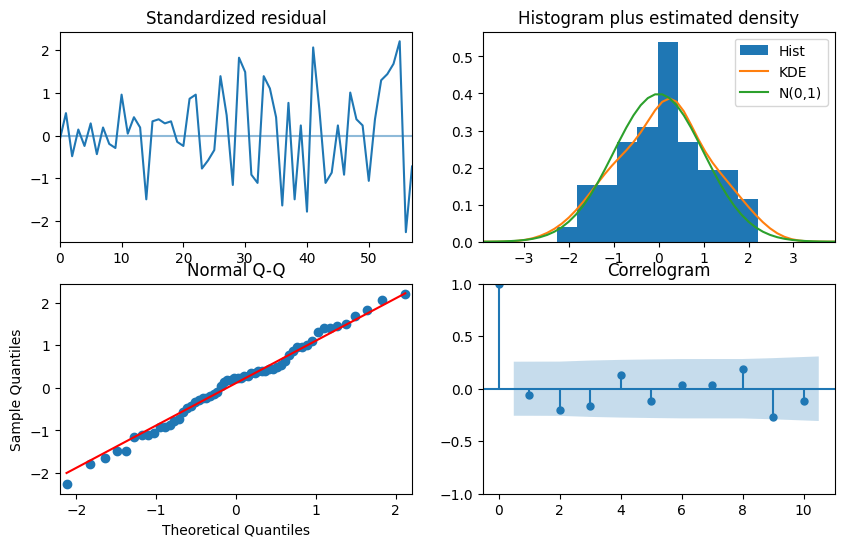

In [83]:
from pmdarima.arima import auto_arima
model = auto_arima(
    train,       # Your time series data
    start_p=0, max_p=12,        # Range for p
    start_d=0, max_d=3,         # Range for d
    start_q=0, max_q=12,        # Range for q
    seasonal=False,             # Set to True if you expect seasonality
    stepwise=True,              # Use stepwise search to find the best parameters
    suppress_warnings=True,     # Suppress convergence warnings
    trace=True                  # Print the progress
)

# Print the best ARIMA order
print(f"Best ARIMA order: {model.order}")

# Plot diagnostics
model.plot_diagnostics(figsize=(10, 6))
plt.show()

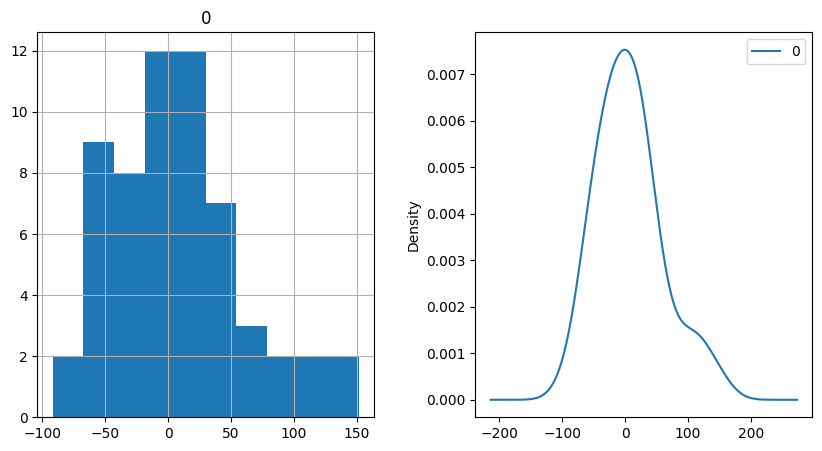

In [84]:
residuals = [test[i] - predictions[i] for i in range(len(test))]
residuals =pd.DataFrame(residuals)
plt.figure(figsize=(10,5))
plt.subplot(121)
residuals.hist(ax=plt.gca())
plt.subplot(122)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

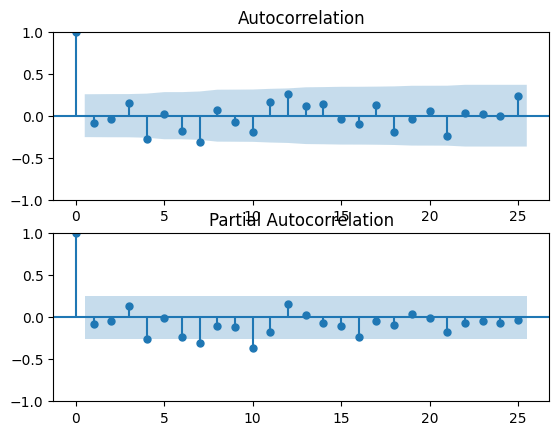

In [85]:
plt.figure()
plt.subplot(211)
plot_acf(residuals, lags=25, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, lags=25, ax=plt.gca())
plt.show()

#Box Cox transformation

Lambda: 0.316780


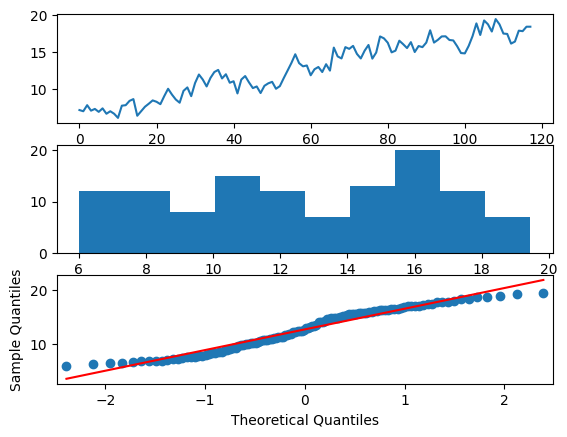

In [86]:
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
transformed, lam = boxcox(series.values.flatten())
print('Lambda: %f' % lam)
plt.figure(1)
# line plot
plt.subplot(311)
plt.plot(transformed)
# histogram
plt.subplot(312)
plt.hist(transformed)
# q-q plot
plt.subplot(313)
qqplot(transformed, line='r', ax=plt.gca())
plt.show()

Some observations from these plots are follows:

* The large fluctuations have been removed from the line plot of the time series.
* The histogram shows a flatter or more uniform (well behaved) distribution of values.
* The Q-Q plot is reasonable, but still not a perfect fit for a Gaussian distribution.

In [88]:
from math import log
from math import exp
# invert box-cox transform
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# transform
	transformed, lam = boxcox(series.values.flatten())
	if lam < -5:
		transformed, lam = history, 1
	# predict
	model = ARIMA(transformed, order=(0,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	# invert transformed prediction
	yhat = boxcox_inverse(yhat, lam)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=415.784, Expected=178.000
>Predicted=415.784, Expected=136.000
>Predicted=415.784, Expected=161.000
>Predicted=415.784, Expected=171.000
>Predicted=415.784, Expected=149.000
>Predicted=415.784, Expected=184.000
>Predicted=415.784, Expected=155.000
>Predicted=415.784, Expected=276.000
>Predicted=415.784, Expected=224.000
>Predicted=415.784, Expected=213.000
>Predicted=415.784, Expected=279.000
>Predicted=415.784, Expected=268.000
>Predicted=415.784, Expected=287.000
>Predicted=415.784, Expected=238.000
>Predicted=415.784, Expected=213.000
>Predicted=415.784, Expected=257.000
>Predicted=415.784, Expected=293.000
>Predicted=415.784, Expected=212.000
>Predicted=415.784, Expected=246.000
>Predicted=415.784, Expected=353.000
>Predicted=415.784, Expected=339.000
>Predicted=415.784, Expected=308.000
>Predicted=415.784, Expected=247.000
>Predicted=415.784, Expected=257.000
>Predicted=415.784, Expected=322.000
>Predicted=415.784, Expected=298.000
>Predicted=415.784, Expected=273.000
>

#Finalize model

In [93]:
# load data
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True)
# prepare data
X = series.values
X = X.astype('float32')
# transform data
transformed, lam = boxcox(X.flatten())
# fit model
model = ARIMA(transformed, order=(0,1,2))
model_fit = model.fit()
# save model
model_fit.save('model.pkl')
np.save('model_lambda.npy', [lam])

#Validate Model

In [95]:
validation = pd.read_csv('validation.csv', header=None, index_col=0, parse_dates=True)
y = validation.values.astype('float32')

>Predicted=452.366, Expected=452.000
>Predicted=452.366, Expected=391.000
>Predicted=452.366, Expected=500.000
>Predicted=452.366, Expected=451.000
>Predicted=452.366, Expected=375.000
>Predicted=452.366, Expected=372.000
>Predicted=452.366, Expected=302.000
>Predicted=452.366, Expected=316.000
>Predicted=452.366, Expected=398.000
>Predicted=452.366, Expected=394.000
>Predicted=452.366, Expected=431.000
>Predicted=452.366, Expected=431.000
RMSE: 74.701


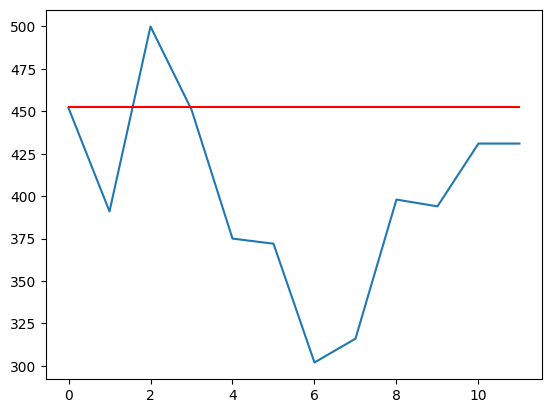

In [98]:
# make first prediction
history = [x for x in X]
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# transform
	transformed, lam = boxcox(series.values.flatten())
	if lam < -5:
		transformed, lam = history, 1
	# predict
	model = ARIMA(transformed, order=(0,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	# invert transformed prediction
	yhat = boxcox_inverse(yhat, lam)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
plt.plot(y)
plt.plot(predictions, color='red')
plt.show()

In [101]:
# evaluate the finalized model on the validation dataset
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import exp
from math import log
import numpy

# invert box-cox transform
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True)
X = dataset.values.astype('float32')
history = [x for x in X]
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
lam = numpy.load('model_lambda.npy')
# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# transform
	transformed, lam = boxcox(history)
	if lam < -5:
		transformed, lam = history, 1
	# predict
	model = ARIMA(transformed, order=(0,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]

	# invert transformed prediction
	yhat = boxcox_inverse(yhat, lam)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

>Predicted=452.367, Expected=451.000


ValueError: Data must be 1-dimensional.